In [1]:
import re
from tqdm import tqdm_notebook as tqn
import numpy as np
import pandas as pd
import tensorflow as tf
import sys
sys.path.append('../')
from dataset import Dataset, DatasetIndex, Batch, action, model
from matplotlib import pyplot as plt
%matplotlib inline

# Functions to generate data

In [2]:
def generate_linear_data(lenght = 10,seed = 10):
    y = np.linspace(0,10,lenght)
    np.random.seed(seed)
    X = y + np.random.random(lenght) - 0.5
    return X,y

def generate_logistic_data(lenght = 10,seed = 10):
    np.random.seed(seed)
    X = np.array(np.random.randint(-10, 10, lenght),dtype=np.float32)
    y = np.array([1. if i > 0 else 0. for i in X])
    return X,y


def generate_poisson_data(lambd, lenght=10, seed=10):
    np.random.seed(seed)
    y = np.random.poisson(lambd, size=lenght)
    X = np.random.uniform(0,np.exp(-lambd), lenght)
    for _ in range(2):
        X = np.vstack(( X, np.random.uniform(0, np.exp(-lambd), lenght)))
    return X.T,y

# Create class

In [3]:
class MyBatch(Batch):
    def __init__(self, index, *args, **kwargs):
        super().__init__(index, *args, **kwargs)
    
    @property
    def components(self):
        return 'x', 'y','W','b','loss'
    
    @action
    def generate(self, lenght = 10, ttype = "linear"):
        if self.x == None or self.y == None:
            self = self.load(lenght,ttype)
        
        self.x, self.y = self.x[self.indices], self.y[self.indices]
        return self
    
    @action
    def load(self, lenght = 10, fmt = None,ttype = 'linear'):  
        exec('self.x, self.y = generate_{}_data(lenght)'.format(ttype))
        return self
    
    @model()
    def linear_model():
        X = tf.placeholder(name='input',dtype=tf.float32)
        y = tf.placeholder(name='true_y',dtype=tf.float32)
        
        W = tf.Variable(np.random.randint(-1,1,size=1),name='weight',dtype=tf.float32)
        b = tf.Variable(np.random.randint(-1,1),dtype=tf.float32)

        predict = tf.multiply(W,X,name='output') + b
        loss = tf.reduce_mean(tf.square(predict - y))

        optimize = tf.train.GradientDescentOptimizer(learning_rate = 0.007)
        train = optimize.minimize(loss)
        
        return [[X, y],[train, loss],[W,b]]
    
    @action(model='linear_model')
    def train_linear_model(self,model,session):
       # print(self.x,self.y)
        X,y = model[0]
        optimizer, cost = model[1]
        params = model[2]
        _, loss, params = session.run([optimizer, cost, params], feed_dict={X:self.x, y: self.y})
        self.W = params[0][0]
        self.b = params[1]
        self.loss = loss
        print('loss: {} | params: {}, {}'.format(loss, self.W, self.b))
        return self
    
    @model()
    def logistic_model():
        X = tf.placeholder(name='input',dtype=tf.float32)
        y = tf.placeholder(name='true_y',dtype=tf.float32)
        
        W = tf.Variable(np.random.randint(-1,1,size=1),name='weight',dtype=tf.float32)
        b = tf.Variable(np.random.randint(-1,1),dtype=tf.float32)

        predict = tf.sigmoid(tf.multiply(W,X,name='output') + b)
        loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y,logits=predict)
        
        optimize = tf.train.GradientDescentOptimizer(learning_rate = 0.001)
        train = optimize.minimize(loss)
        return [[X, y],[train, loss, predict],[W,b]]

    @action(model='logistic_model')
    def train_logistic_model(self, model, session, result, test):
       # print(self.x,self.y)
        X,y = model[0]
        optimizer, cost, predict = model[1]
        params = model[2]
        _, loss, params = session.run([optimizer, cost, params], feed_dict={X:self.x, y: self.y})
        self.W = params[0][0]
        self.b = params[1]
        self.loss = loss
        print('loss: {} | params: {}, {}'.format(loss, self.W, self.b))
        result[:] = sess.run([predict], feed_dict={X:test})[0]
        return self
    
    @model()
    def poission_model():
        
        X = tf.placeholder(name='input',shape = [None,3],dtype=tf.float32)
        y = tf.placeholder(name='true_y',dtype=tf.float32)
        
        W = tf.Variable(np.random.randint(-1,1,size=3).reshape(3,1),name='weight',dtype=tf.float32)
        #b = tf.Variable(np.random.randint(-1,1),dtype=tf.float32)

        predict = tf.exp(tf.matmul(X,W))
        loss = tf.nn.log_poisson_loss(y,predict)#tf.reduce_sum(tf.matmul(y,tf.matmul(X,W)) - predict)
        optimize = tf.train.GradientDescentOptimizer(learning_rate = 0.001)
        train = optimize.minimize(loss)
        return [[X, y],[train, loss, predict],[W]]
    
    @action(model='logistic_model')
    def train_poisson_model(self, model, session):#, result, test):
        X,y = model[0]
        optimizer, cost, predict = model[1]
        params = model[2]
        _, loss, params = session.run([optimizer, cost, params], feed_dict={X:self.x, y: self.y})
        self.W = params[0]
        self.loss = loss
        print('loss: {} | params: {}, {}'.format(loss, self.W, self.b))
        result[:] = sess.run([predict], feed_dict={X:test})[0]
        return self

#  train poisson regression

In [4]:
# train poisson regression

len_data = 100
ix = DatasetIndex(np.arange(len_data))

dset = Dataset(ix,MyBatch)
sess = tf.Session()
sess.run(tf.global_variables_initializer())
i = 0
test = np.array([-10,10,-1,-1,-1,1])
result = np.zeros(len(test),dtype = np.float32)
X,y = generate_logistic_data(len_data)
for batch in tqn(dset.gen_batch(10,n_epochs=1)):
    batch.generate(len_data,ttype = 'poisson').train_poisson_model(sess)
    #print(test,'\n',result,'\n\n')

Widget Javascript not detected.  It may not be installed or enabled properly.


loss: [ 0.97407699  0.92357194  0.8730669   0.82256186  0.77205682  0.72155178
  0.67104667  0.62054163  0.57003659  0.51953149] | params: [ -2.39812362e-05], None
loss: [ 0.46906999  0.41857728  0.36808074  0.31758922  0.26709756  0.21660364
  0.16611141  0.11561593  0.06512755  0.01463369] | params: [ 0.00355223], None
loss: [-0.03917295 -0.08950722 -0.14068487 -0.19202703 -0.24258861 -0.29350606
 -0.34478083 -0.3955678  -0.44682789 -0.49774829] | params: [ 0.01527199], None
loss: [-0.57550621 -0.62571174 -0.6824441  -0.72946799 -0.77997863 -0.8352645
 -0.88623095 -0.94782889 -0.99172008 -1.05228806] | params: [ 0.03998164], None
loss: [-1.19666314 -1.26458287 -1.30133379 -1.38404846 -1.42436922 -1.49905717
 -1.5405252  -1.62387073 -1.6608187  -1.71382523] | params: [ 0.08329645], None
loss: [-2.02368093 -2.06723547 -2.20366001 -2.21338463 -2.30658484 -2.43224168
 -2.50969648 -2.53056645 -2.64118171 -2.6559639 ] | params: [ 0.14685631], None
loss: [-3.24088478 -3.37883067 -3.40909958

# train logistic regression

In [4]:
len_data = 100
ix = DatasetIndex(np.arange(len_data))

dset = Dataset(ix,MyBatch)
sess = tf.Session()
sess.run(tf.global_variables_initializer())
i = 0
test = np.array([-10,10,-1,-1,-1,1])
result = np.zeros(len(test),dtype = np.float32)
X,y = generate_logistic_data(len_data)
for batch in tqn(dset.gen_batch(10,n_epochs=1)):
    batch.generate(len_data,ttype = 'logistic').train_logistic_model(sess, result, test)
    print(test,'\n',result,'\n\n')

loss: [ 0.97407699  0.92357194  0.8730669   0.82256186  0.77205682  0.72155178
  0.67104667  0.62054163  0.57003659  0.51953149] | params: -2.3981236154213548e-05, -0.0004197847447358072
[-10  10  -1  -1  -1   1] 
 [ 0.499955    0.49983507  0.49990109  0.49990109  0.49990109  0.49988905] 


loss: [ 0.46906999  0.41857728  0.36808074  0.31758922  0.26709756  0.21660364
  0.16611141  0.11561593  0.06512755  0.01463369] | params: 0.0035522254183888435, 0.001685750437900424
[-10  10  -1  -1  -1   1] 
 [ 0.49154168  0.50930095  0.49953339  0.49953339  0.49953339  0.50130945] 


loss: [-0.03917295 -0.08950722 -0.14068487 -0.19202703 -0.24258861 -0.29350606
 -0.34478083 -0.3955678  -0.44682789 -0.49774829] | params: 0.015271992422640324, 0.006314799189567566
[-10  10  -1  -1  -1   1] 
 [ 0.46346393  0.53967506  0.49776071  0.49776071  0.49776071  0.50539649] 


loss: [-0.57550621 -0.62571174 -0.6824441  -0.72946799 -0.77997863 -0.8352645
 -0.88623095 -0.94782889 -0.99172008 -1.05228806] | par

# train linear regression

loss: 2.1998775005340576 | params: 0.008177659474313259, -0.9796363711357117
loss: 5.993888854980469 | params: 0.06349582225084305, -0.9455981254577637
5.99389


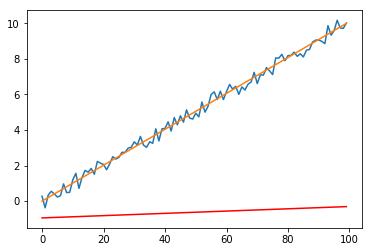

loss: 10.720087051391602 | params: 0.17788007855415344, -0.8999123573303223
loss: 14.30145263671875 | params: 0.36009442806243896, -0.8470949530601501
14.3015


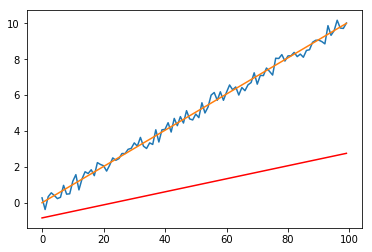

loss: 13.865659713745117 | params: 0.5952819585800171, -0.795067310333252
loss: 9.065546035766602 | params: 0.8277196884155273, -0.7530012130737305
9.06555


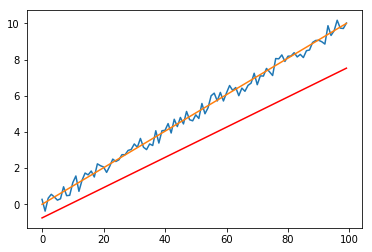

loss: 3.72857928276062 | params: 1.0007658004760742, -0.7261785268783569
loss: 0.6419097185134888 | params: 1.0771914720535278, -0.7157411575317383
0.64191


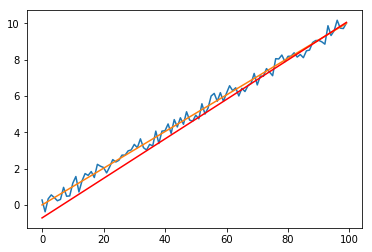

loss: 0.06747522950172424 | params: 1.0965033769607544, -0.7133969068527222
loss: 0.13279426097869873 | params: 1.0687167644500732, -0.7161547541618347
0.132794


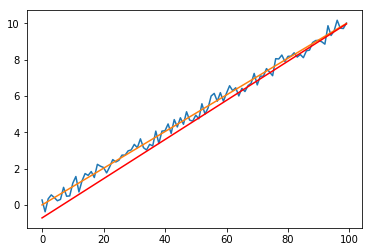

In [5]:
len_data = 100
ix = DatasetIndex(np.arange(len_data))

dset = Dataset(ix,MyBatch)
sess = tf.Session()
sess.run(tf.global_variables_initializer())
i = 0
X,y = generate_linear_data(len_data)
for batch in tqn(dset.gen_batch(10,n_epochs=1)):
   # print(i.indices)
    batch.generate(len_data).train_linear_model(sess)
    i +=1
    if i == 2:
        print(batch.loss)
        i = 0
        plt.plot(X)
        plt.plot(y)
        plt.plot(batch.W * y + batch.b, c ='r')
        plt.show()